In [2]:
# Importation des librairies

import numpy as np 
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import sys
import time
import os
sys.path.append(os.path.dirname(os.getcwd()))

from code_project.data_science.utils_project import load_saved_file, read_feel, process_label, process_nlp, vectorize, apply_vectorization
from code_project.data_science.evaluate import load_test_set, evaluate_model
from code_project.config_project import *

Using TensorFlow backend.


In [3]:
# Lecture des données
PATH_DATA = "data/kaggle-traduction/translate_final_lemmatized.csv"

data = pd.read_csv(PATH_DATA, sep=";", encoding='utf-8')
data = data.drop(['Unnamed: 0'], axis=1)
data = data.fillna("")

data.head()

,sentiment,translation,translation_yandex,translation_microsoft,translation_google,nlp_google
0,empty,"@ tiffanylue je sais, j’écoutais la mauvaise h...",@tiffanylue je sais je suis listenin à mauvais...,@tiffanylue je sais je suis listenin à mauvais...,@ tiffanylue je sais que j’écoutais la mauvais...,"['savoir', 'ecoutais', 'mauvaise', 'habitude',..."
1,sadness,Allongé sur mon lit avec un mal de tête ughhhh...,Laporal n lit avec un mal de tête pouah... wai...,Laporal n lit avec un mal de tête Pouah... wai...,Layin n lit avec un mal de tête ughhhh ... att...,"['layin', 'n', 'lire', 'mal', 'tete', 'ughhhh'..."
2,sadness,Cérémonie funéraire... vendredi sombre...,Cérémonie funéraire... vendredi sombre...,Cérémonie funéraire... vendredi sombre...,Cérémonie funèbre ... triste vendredi ...,"['ceremonie', 'funebre', 'triste', 'vendredi']"
3,enthusiasm,veut sortir avec des amis BIENTOT!,veut passer du temps avec des amis bientôt !,veut passer du temps avec des amis bientôt !,veut sortir avec des amis bientôt!,"['vouloir', 'sortir', 'amis', 'bientot']"
4,neutral,@dannycastillo On veut échanger avec quelqu’un...,@dannycastillo nous voulons commerce avec quel...,@dannycastillo nous voulons commerce avec quel...,@dannycastillo Nous voulons échanger avec quel...,"['vouloir', 'echanger', 'quelqu', 'avoir', 'bi..."


In [4]:
TEST_SET_PATH = "data/test_set_trad_lem.csv"
data_test = pd.read_csv(TEST_SET_PATH, sep=";", encoding='utf-8')
data_test.head()

,Unnamed: 0,phrase,emotion,phrase_lem
0,0,Il est triste de se dire que KH3 est le dernie...,sadness,"['triste', 'dire', 'kh3', 'dernier', 'kingdom'..."
1,1,Aujourd'hui pour moi tout va mal c'est terribl...,sadness,"['aujourd', 'hui', 'tout', 'aller', 'mal', 'te..."
2,2,il fait beau,neutral,"['faire', 'beau']"
3,3,tu me parles plus je suis triste,sadness,"['parler', 'plaire', 'triste']"
4,4,j’espère être encore de ce monde pour te parl...,sadness,"['espere', 'etre', 'encore', 'monder', 'parler..."


In [5]:
# On ne garde que certains sentiments
data.loc[data.sentiment == 'hate', ['sentiment']] = 'anger'
data.loc[data.sentiment == 'enthusiasm', ['sentiment']] = 'joy'
data.loc[data.sentiment == 'fun', ['sentiment']] = 'joy'
data.loc[data.sentiment == 'worry', ['sentiment']] = 'fear'
data.loc[data.sentiment == 'happiness', ['sentiment']] = 'joy'
data.loc[data.sentiment == 'love', ['sentiment']] = 'love'
data = data.loc[~data.sentiment.isin(['boredom', 'relief', 'empty'])]
data.sentiment.value_counts()

fear        7433
neutral     6340
sadness     4828
joy         4596
love        2068
surprise    1613
anger       1285
Name: sentiment, dtype: int64

In [6]:
data.head(6)

,sentiment,translation,translation_yandex,translation_microsoft,translation_google,nlp_google
1,sadness,Allongé sur mon lit avec un mal de tête ughhhh...,Laporal n lit avec un mal de tête pouah... wai...,Laporal n lit avec un mal de tête Pouah... wai...,Layin n lit avec un mal de tête ughhhh ... att...,"['layin', 'n', 'lire', 'mal', 'tete', 'ughhhh'..."
2,sadness,Cérémonie funéraire... vendredi sombre...,Cérémonie funéraire... vendredi sombre...,Cérémonie funéraire... vendredi sombre...,Cérémonie funèbre ... triste vendredi ...,"['ceremonie', 'funebre', 'triste', 'vendredi']"
3,joy,veut sortir avec des amis BIENTOT!,veut passer du temps avec des amis bientôt !,veut passer du temps avec des amis bientôt !,veut sortir avec des amis bientôt!,"['vouloir', 'sortir', 'amis', 'bientot']"
4,neutral,@dannycastillo On veut échanger avec quelqu’un...,@dannycastillo nous voulons commerce avec quel...,@dannycastillo nous voulons commerce avec quel...,@dannycastillo Nous voulons échanger avec quel...,"['vouloir', 'echanger', 'quelqu', 'avoir', 'bi..."
5,fear,Re-ping @ ghostridah14: pourquoi n’êtes-vous p...,@ghostridah14 re-ping : Pourquoi n’allez-vous ...,@ghostridah14 re-ping : Pourquoi n’allez-vous ...,Re-ping @ ghostridah14: pourquoi n’êtes-vous p...,"['re', 'ping', 'pourquoi', 'n', 'etes', 'pas',..."
6,sadness,"Je devrais dormir, mais impossible! pense à un...","Je devrais être le sommeil, mais je ne suis pa...","Je devrais être le sommeil, mais je ne suis pa...","Je devrais dormir, mais pas! penser à un vieil...","['devoir', 'dormir', 'pas', 'penser', 'avoir',..."


In [7]:
# liste contenant le vocabulaire
vocab = []
for i in data.index:
    for word in data['nlp_google'][i][2:-2].split('\', \''):
        vocab.append(word)
print(len(vocab))
print(len(set(vocab)))

258538
23089


In [8]:
vocab = list(set(vocab))

In [10]:
import ast
def literal_return(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError) as e:
        return val
data['nlp_google'] = data['nlp_google'].apply(literal_return)

In [11]:
max_features = data['nlp_google'].count()
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['nlp_google'].values)

print(data['nlp_google'].values)
X_train = tokenizer.texts_to_sequences(data['nlp_google'].values)
print(X_train[1])

X_train = pad_sequences(X_train, padding='pre', maxlen=50)

print('train shape : {}'.format((len(X_train), len(X_train[0]))))

[list(['layin', 'n', 'lire', 'mal', 'tete', 'ughhhh', 'attendre', 'appel'])
 list(['ceremonie', 'funebre', 'triste', 'vendredi'])
 list(['vouloir', 'sortir', 'amis', 'bientot']) ...
 list(['comedie', 'bonne', 'chance', 'ami'])
 list(['stephs', 'grad', 'party', 'gr8', 'pousser', 'gateau', 'visage', 'watchd', 'seoir', 'chienner', 'gifler', 'garcon', 'manger', 'bonne', 'nourriture', 'satisfaire'])
 list(['sweeeeet', 'san', 'fran', 'genial', 'aimer', 'bas'])]
[2937, 9637, 56, 149]
train shape : (28163, 50)


In [12]:
import pickle
with open("./data/polyglot-fr.pkl", 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        idx2word, embeddings = u.load()

In [13]:
words = [x.lower() for x in list(idx2word)]

In [14]:
# mots de notre dataset dont on a pas d'embedding dans polyglot : beaucoup de mots anglais 
# qui n'ont pas passé la traduction
set(list(tokenizer.word_index.keys())) - set(words)

In [20]:
## SETTING EMBEDDING WEIGHTS AND PARAMETERS
embed_dim = 64
embedding_weights = {key: embeddings[words.index(word)] if word in words else
                     np.random.uniform(-0.25, 0.25, embed_dim)
                     for word, key in tokenizer.word_index.items()}
embedding_weights[0] = np.zeros(embed_dim)

In [21]:
# Définition du modèle de deep learning à utiliser
lstm_out = 196
from keras import regularizers
model = Sequential()
model.add(Embedding(len(embedding_weights), embed_dim, input_length = X_train.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(7, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 64)            1477696   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               204624    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 1379      
Total params: 1,683,699
Trainable params: 1,683,699
Non-trainable params: 0
_________________________________________________________________


In [22]:
len(embeddings[0])

64

In [23]:
## INITIALIZE EMBEDDING LAYER WITH EMBEDDING WEIGHTS
weights = np.array([v for v in embedding_weights.values()])
embedding_layer = model.get_layer('embedding_1')
embedding_layer.set_weights([weights])

In [ ]:
from keras.utils import plot_model
import pydot

In [ ]:
plot_model(model, to_file='model.png')

In [25]:
# Split the output
df_Y = pd.get_dummies(data['sentiment'])
Y = df_Y.values
labels = list(df_Y.columns)
map_label = {}
for i, val in enumerate(labels):
    map_label[i] = val
print(Y)
print(map_label)

[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]]
{0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'neutral', 5: 'sadness', 6: 'surprise'}


In [26]:
# Fit the model
batch_size = 32
model.fit(X_train, Y, epochs = 10, batch_size=batch_size, verbose = 2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
 - 53s - loss: 1.7521 - acc: 0.2959
Epoch 2/10
 - 54s - loss: 1.6515 - acc: 0.3525
Epoch 3/10
 - 54s - loss: 1.5532 - acc: 0.3981
Epoch 4/10
 - 54s - loss: 1.4628 - acc: 0.4369
Epoch 5/10
 - 54s - loss: 1.3751 - acc: 0.4788
Epoch 6/10
 - 55s - loss: 1.2726 - acc: 0.5250
Epoch 7/10
 - 55s - loss: 1.1734 - acc: 0.5642
Epoch 8/10
 - 58s - loss: 1.0798 - acc: 0.6043
Epoch 9/10
 - 65s - loss: 1.0045 - acc: 0.6315
Epoch 10/10
 - 61s - loss: 0.9364 - acc: 0.6572


In [27]:
def most_common(lst):
    lst = [el for el in lst if el != 'no_emotion']
    if len(lst) == 0:
        return 'no_emotion'
    else:
        return max(set(lst), key=lst.count)
    
def predict(x_test, tokenizer, model, predict_word):
    
    predictions = []
    
    for sentence in x_test:
        if predict_word:
            list_emotion_word = []
            for word in sentence.split(" "):  
                txt = tokenizer.texts_to_sequences([word])
                txt = pad_sequences(txt, maxlen=50)
                sentiment = model.predict(txt, batch_size=1, verbose = 2)[0]
                list_emotion_word.append(map_label[np.argmax(sentiment)])
            predictions.append(most_common(list_emotion_word))
        else:
            txt = tokenizer.texts_to_sequences([sentence])
            txt = pad_sequences(txt, maxlen=50)
            sentiment = model.predict(txt, batch_size=1, verbose = 2)[0]
            predictions.append(map_label[np.argmax(sentiment)])
    
    return predictions

In [28]:
import ast
def literal_return(val):
    try:
        return ast.literal_eval(val)
    except (ValueError, SyntaxError) as e:
        return val
data_test['phrase_lem'] = data_test['phrase_lem'].apply(literal_return)

In [29]:
# Calcul du score final
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
pd.set_option('display.max_colwidth', -1)

y_test = y_test = data_test['emotion']

predictions = predict(data_test['phrase_lem'], tokenizer, model, predict_word=False)

accuracy = accuracy_score(y_test, predictions)
conf_mat = confusion_matrix(y_test, predictions)

print(accuracy)
print(conf_mat)

0.41132075471698115
[[ 2 12  2  1 14  4  1]
 [ 3 19  3  0 16  0  0]
 [ 0  3 30  4  8  2  1]
 [ 0  1  7 12  1  0  0]
 [ 0  6  6  0 27  1  0]
 [ 0 15  1  0  8 13  0]
 [ 0 10 13  2 11  0  6]]


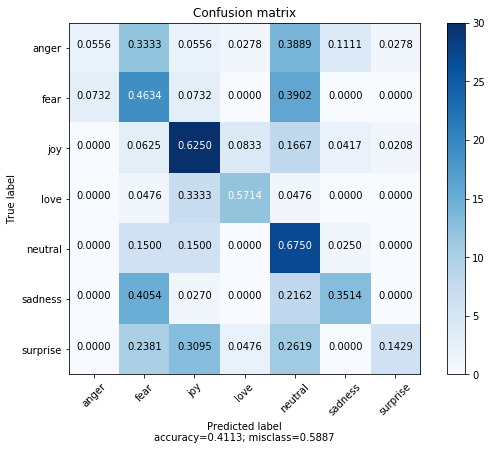

In [32]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    cm is the confusion matrix to use
    target names is the list of labels
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
plot_confusion_matrix(conf_mat, target_names=['anger','fear', 'joy', 'love', 'neutral', 'sadness', 'surprise'])

In [33]:
print({0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'neutral', 5: 'sadness', 6: 'surprise'})

{0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'neutral', 5: 'sadness', 6: 'surprise'}


In [34]:
data_test['predictions'] = predictions

In [39]:
data_test.sample(5)

,Unnamed: 0,phrase,emotion,phrase_lem,predictions
208,208,"Il avait la trouille de se jeter, on a du le pousser",fear,"[trouille, jeter, avoir, pousser]",neutral
10,10,Les mots blessent vous savez,sadness,"[les, mots, blesser, savoir]",sadness
197,197,"Il a été pris d'un fou rire, il ne pouvait plus s'arrêter de rigoler",joy,"[avoir, ete, prendre, fou, rire, ne, pouvoir, plaire, arreter, rigoler]",joy
91,91,Tension sur le plateau,anger,"[tension, plateau]",fear
183,183,Je suis très déçu qu'il n'est pas pu venir,sadness,"[tres, decu, n, pas, pouvoir, venir]",sadness


In [40]:
data_test.to_csv('first_result_with_lem.csv')

# Test GRU

In [16]:
# Importation des librairies

import numpy as np 
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, GRU
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import sys
import time
import os
sys.path.append(os.path.dirname(os.getcwd()))

from code_project.data_science.utils_project import load_saved_file, read_feel, process_label, process_nlp, vectorize, apply_vectorization
from code_project.data_science.evaluate import load_test_set, evaluate_model
from code_project.config_project import *

In [2]:
# Lecture des données
PATH_DATA = "data/kaggle-traduction/translate_final_lemmatized.csv"

data = pd.read_csv(PATH_DATA, sep=";", encoding='utf-8')
data= data.drop(['Unnamed: 0'], axis=1)
data = data.fillna("")
data.head(5)

# Si True alors on prédit sur chaque mot puis on agrège la prédiction
PREDICT_WORD = True

In [6]:
TEST_SET_PATH = "data/test_set_trad_lem.csv"
data_test = pd.read_csv(TEST_SET_PATH, sep=";", encoding='utf-8')
data_test.sample(5)

,Unnamed: 0,phrase,emotion,phrase_lem
201,201,Il était vraiment très anxieux à l'attente de ...,fear,"['etait', 'vraiment', 'tres', 'anxieux', 'avoi..."
2,2,il fait beau,neutral,"['faire', 'beau']"
176,176,Stefano pestait contre les nids de poules qui ...,anger,"['stefano', 'pester', 'contrer', 'les', 'nids'..."
256,256,J'adore aller me balader dans Paris ! Cette vi...,love,"['adorer', 'aller', 'balader', 'paris', 'cette..."
223,223,Ah Marc vient finalement à la soirée ? Je pens...,surprise,"['ah', 'marc', 'venir', 'finalement', 'avoir',..."


In [11]:
data.sample(3)

,sentiment,translation,translation_yandex,translation_microsoft,translation_google,nlp_google,nlp_sentence
18124,fear,,"Pauvre Johnny est malade, on dirait qu'il va l...",Pauvre Johnny est malade on dirait qu’il vais ...,Le pauvre Johnny est malade On dirait qu'il ir...,"['pauvre', 'johnny', 'malade', 'dire', 'aller'...",pauvr johnny malad dir ira chez veterinair demain
1767,sadness,,@itstayloryall Im si triste que vous nous avez...,@itstayloryall Im si triste que vous nous avez...,@ itstayloryall Je suis si triste que tu nous ...,"['si', 'triste', 'manquer', 'avoir', 'reunion'...",si trist manqu a reunion famill
1982,neutral,,"doit aller au lit, mais ne peut pas dormir tou...","doit aller au lit, mais ne peut pas dormir tou...",devrait aller au lit mais ne peut pas dormir m...,"['devoir', 'aller', 'lire', 'ne', 'pouvoir', '...",devr aller lit ne peut pas dorm mainten


In [7]:
# On ne garde que certains sentiments
data.loc[data.sentiment == 'hate', ['sentiment']] = 'anger'
data.loc[data.sentiment == 'enthusiasm', ['sentiment']] = 'joy'
data.loc[data.sentiment == 'fun', ['sentiment']] = 'joy'
data.loc[data.sentiment == 'worry', ['sentiment']] = 'fear'
data.loc[data.sentiment == 'happiness', ['sentiment']] = 'joy'
data.loc[data.sentiment == 'love', ['sentiment']] = 'love'
data = data.loc[~data.sentiment.isin(['boredom', 'relief', 'empty'])]
data.sentiment.value_counts()

fear        7433
neutral     6340
sadness     4828
joy         4596
love        2068
surprise    1613
anger       1285
Name: sentiment, dtype: int64

In [12]:
max_features = data['nlp_google'].count()
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['nlp_google'].values)
X_train = tokenizer.texts_to_sequences(data['nlp_google'].values)
X_train = pad_sequences(X_train, padding='pre', maxlen=50)

print('train shape : {}'.format((len(X_train), len(X_train[0]))))

train shape : (28163, 50)


In [13]:
import gensim 
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(data['nlp_google'].values)

In [14]:
max_features = data['nlp_google'].count()
max_features

28163

In [17]:
# Définition du modèle de deep learning à utiliser
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length = X_train.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(GRU(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(7, activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 50, 128)           3604864   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 50, 128)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 196)               191100    
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 1379      
Total params: 3,797,343
Trainable params: 3,797,343
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Split the output
df_Y = pd.get_dummies(data['sentiment'])
Y = df_Y.values
labels = list(df_Y.columns)
map_label = {}
for i, val in enumerate(labels):
    map_label[i] = val
print(Y)
print(map_label)

[[0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]]
{0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'neutral', 5: 'sadness', 6: 'surprise'}


In [19]:
# Fit the model
batch_size = 64
model.fit(X_train, Y, epochs = 10, batch_size=batch_size, verbose = 2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
 - 64s - loss: 1.6902 - acc: 0.3300
Epoch 2/10
 - 62s - loss: 1.4815 - acc: 0.4350
Epoch 3/10
 - 63s - loss: 1.2920 - acc: 0.5185
Epoch 4/10
 - 62s - loss: 1.1019 - acc: 0.5994
Epoch 5/10
 - 59s - loss: 0.9416 - acc: 0.6668
Epoch 6/10
 - 59s - loss: 0.8142 - acc: 0.7116
Epoch 7/10
 - 57s - loss: 0.7227 - acc: 0.7438
Epoch 8/10
 - 58s - loss: 0.6538 - acc: 0.7659
Epoch 9/10
 - 60s - loss: 0.5935 - acc: 0.7857
Epoch 10/10
 - 58s - loss: 0.5469 - acc: 0.8047


In [20]:
def most_common(lst):
    lst = [el for el in lst if el != 'no_emotion']
    if len(lst) == 0:
        return 'no_emotion'
    else:
        return max(set(lst), key=lst.count)
    
def predict(x_test, tokenizer, model, predict_word):
    
    predictions = []
    
    for sentence in x_test:
        if predict_word:
            list_emotion_word = []
            for word in sentence.split(" "):
                txt = tokenizer.texts_to_sequences([word])
                txt = pad_sequences(txt, maxlen=50)
                sentiment = model.predict(txt, batch_size=1, verbose = 2)[0]
                list_emotion_word.append(map_label[np.argmax(sentiment)])
            predictions.append(most_common(list_emotion_word))
        else:
            txt = tokenizer.texts_to_sequences([sentence])
            txt = pad_sequences(txt, maxlen=50)
            sentiment = model.predict(txt, batch_size=1, verbose = 2)[0]
            predictions.append(map_label[np.argmax(sentiment)])
    
    return predictions

In [23]:
# Calcul du score final
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
pd.set_option('display.max_colwidth', -1)

y_test = y_test = data_test['emotion']

predictions = predict(data_test['phrase_lem'], tokenizer, model, predict_word=False)

accuracy = accuracy_score(y_test, predictions)
conf_mat = confusion_matrix(y_test, predictions)

print(accuracy)
print(conf_mat)

0.3660377358490566
[[ 4 12  3  0 13  4  0]
 [ 2 17  5  2  9  2  4]
 [ 0  6 26  5  5  5  1]
 [ 1  2  4 11  1  1  1]
 [ 2  4  7  4 21  2  0]
 [ 0 19  1  1  5  9  2]
 [ 0 11  9  4  7  2  9]]


In [24]:
print({0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'neutral', 5: 'sadness', 6: 'surprise'})

{0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'neutral', 5: 'sadness', 6: 'surprise'}


In [258]:
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import pandas as pd
import numpy as np




plot_confusion_matrix(conf_mat, target_names=['anger','fear', 'joy', 'love', 'neutral', 'sadness', 'surprise'])


<Figure size 800x600 with 2 Axes>